# < 8. 뉴스 요약봇 만들기 >

## [루브릭]
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.

In [2]:
import nltk

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

---

## Step1. 데이터 수집하기

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
print('전체 샘플수 : ', len(data))

전체 샘플수 :  98401


In [6]:
data.sample(10)

,headlines,text
18535,Want babies with Katrina as I have a thing for...,Actor Kartik Aaryan named Katrina Kaif when as...
84325,"Aus cafe forces Indian worker to return wage, ...",The Indian-origin owners of a former coffee sh...
20705,Putin expresses condolences over Kerala flood ...,In a letter addressed to Indian President Ram ...
67901,"Delhi government school rented out at night, t...",Delhi Education Minister Manish Sisodia said t...
85054,"St Stephen's bar highest for Eng, Eco at 98.5%...",Delhi University's St Stephen's on Thursday re...
74735,14 staff members suspended in Rajdhani Express...,"As many as 14 staff members, including seven h..."
34875,BJP MLC 'expelled' from Islam for visiting temple,BJP MLC Bukkal Nawab in Uttar Pradesh has been...
2315,20 Indian fishermen held for allegedly fishing...,At least 20 fishermen from Tamil Nadu have bee...
14040,Depends on players if they take wives on tour ...,Reacting to Virat Kohli's alleged plea to allo...
37250,70-yr-old travels to Russia from Germany in tr...,"Hubert Wirth, a 70-year-old German football fa..."


> 추상적 요약의 경우 text를 본문, headlines를 요약된 데이터로
> <br> 추출적 요약의 경우 오직 text열만 사용

---

## Step2. 데이터 전처리하기

### (1) 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [7]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 : ', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 :  98280


▶ text 자체가 중복이 된 경우에는 중복 샘플이므로 제거한다

In [8]:
data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플수 ; ', len(data))

전체 샘플수 ;  98360


▶ Null 개수 확인

In [9]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### (2) 텍스트 정규화와 불용어 제거
- 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어인 것 처럼 간주되는 경우가 있다
- 이런 단어들을 미리 통일시켜주는 것을 텍스트 정규화라고 한다
- 불용어는 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들을 말한다

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

▶ 이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

▶ 함수의 하단에 있는 불용어 미제거 부분은 상대적으로 문장 길이가 짧은 headlines 전처리할 때는 호출하지 않을 예정이다.

In [13]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [16]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("headline 전처리 후 결과: ", clean_summary[:5])

headline 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


▶ Null값 확인

In [18]:
data['text'] = clean_text
data['headlines'] = clean_summary

data.replace('', np.nan, inplace=True)

In [19]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [20]:
print('전체 샘플수 : ', len(data))

전체 샘플수 :  98360


### (3) 훈련 데이터와 테스트 데이터 나누기

#### ⦁ 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


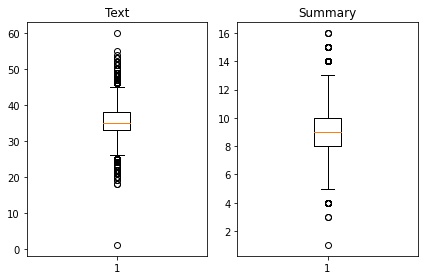

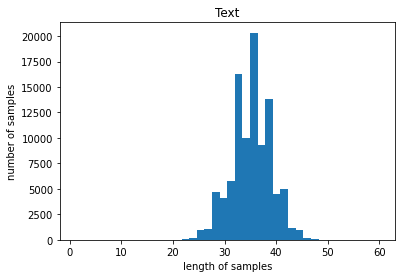

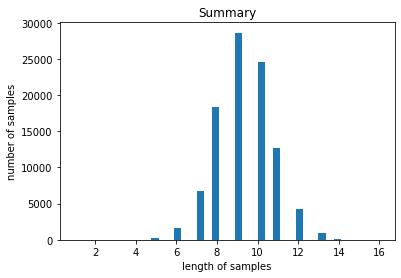

In [21]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

▶ 신뢰구간을 이용해서 적절한 최대 길이를 정한다. ( 평균 + 2표준편차 )

In [22]:
text_max_len = int(np.mean(text_len) + np.std(text_len) * 2)
summary_max_len = int(np.mean(summary_len) + np.std(summary_len) * 2)

text_max_len, summary_max_len

(42, 12)

In [23]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

# 정해진 길이보다 길면 제외
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플 중 길이가 42 이하인 샘플의 비율: 0.9750305002033347
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571
전체 샘플수 : 94754


#### ⦁ 시작 토큰과 종료 토큰 추가하기
- seq2seq 훈련을 위해서 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다
- 시작 토큰은 sostoken, 종료 토큰은 eostoken 이라고 명명하고 앞,뒤로 추가

In [24]:
 # 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### ⦁ 훈련 데이터와 테스트 데이터 분리

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[83510  5551 14567 ... 42079 55714 58656]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18950


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


### (4) 정수 인코딩
- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 한다
- 각 단어에 고유한 정수를 맵핑하는 작업이 필요하다
- 이 과정을 단어 집합을 만든다고 표현

#### ⦁ encoder_input_train

In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

▶ 생성된 단어 집합은 src_tokenizer.word_index에 저장, 빈도수가 낮은 단어들은 훈련 데이터에서 제외

In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67797
등장 빈도가 6번 이하인 희귀 단어의 수: 46128
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21669
단어 집합에서 희귀 단어의 비율: 68.03840877914952
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5442569668577755


▶ encoder_input_train에는 6만여개의 단어가 있다 <br>
▶ 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.54% <br>
▶ 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거 <br>
▶ 이를 제외한 단어 집합의 크기를 2만여개로 계산해서 이와 비슷하게 단어 집합의 크기를 20000 으로 제한

In [32]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[29, 2, 104, 2663, 1807, 1, 319, 1046, 4161, 3495, 17068, 6092, 22, 324, 489, 18970, 24, 16290, 201, 539, 3882, 5844, 963, 3213, 2602, 24, 638, 12234, 6965, 1, 1807, 3495, 1971, 143, 2663, 293, 1, 1450, 160], [7780, 9561, 209, 472, 18971, 6225, 9561, 1036, 199, 6225, 2759, 203, 67, 718, 2259, 62, 1945, 281, 9561, 8, 9989, 1041, 6805, 14, 395, 10948, 529, 1919, 9561, 604, 1441, 13023, 1062, 33, 127], [1576, 164, 19, 7567, 6367, 857, 90, 1751, 954, 5776, 5716, 560, 326, 77, 3290, 2803, 1, 9, 1085, 2787, 4989, 19, 6454, 9, 469, 3291, 18972, 7047, 2803, 4, 2635, 19, 1552, 1751, 139, 857, 86, 861]]


#### ⦁ decoder_input_train

In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29548
등장 빈도가 5번 이하인 희귀 단어의 수: 19325
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10223
단어 집합에서 희귀 단어의 비율: 65.40205766887776
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.756520340890819


In [36]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4415, 2132, 78, 5, 58, 88, 4416, 956], [1, 5056, 497, 327, 946, 3789, 25, 16, 36, 2606, 9, 308], [1, 66, 569, 314, 1296, 41, 4703, 3154, 346, 34], [1, 3155, 349, 605, 322, 106, 772, 17, 3680, 630], [1, 166, 1695, 8, 90, 1231, 4, 910, 12, 979]]
target
decoder  [[4415, 2132, 78, 5, 58, 88, 4416, 956, 2], [5056, 497, 327, 946, 3789, 25, 16, 36, 2606, 9, 308, 2], [66, 569, 314, 1296, 41, 4703, 3154, 346, 34, 2], [3155, 349, 605, 322, 106, 772, 17, 3680, 630, 2], [166, 1695, 8, 90, 1231, 4, 910, 12, 979, 2]]


In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75803
훈련 레이블의 개수 : 75803
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


####  ⦁ 패딩하기

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

---

## Step3. 어텐션 메커니즘 사용하기

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### (1) Encoder

In [40]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### (2) Decoder

In [41]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [42]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### (3) Attention 

In [43]:
from tensorflow.keras.layers import AdditiveAttention

In [44]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### (4) 모델 훈련하기

In [45]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
297/297 [==============================] - 187s 601ms/step - loss: 5.6415 - val_loss: 5.2241
Epoch 2/50
297/297 [==============================] - 175s 589ms/step - loss: 5.0637 - val_loss: 4.8790
Epoch 3/50
297/297 [==============================] - 174s 584ms/step - loss: 4.7346 - val_loss: 4.6114
Epoch 4/50
297/297 [==============================] - 174s 587ms/step - loss: 4.4713 - val_loss: 4.4288
Epoch 5/50
297/297 [==============================] - 173s 583ms/step - loss: 4.2608 - val_loss: 4.2874
Epoch 6/50
297/297 [==============================] - 172s 578ms/step - loss: 4.0863 - val_loss: 4.1517
Epoch 7/50
297/297 [==============================] - 173s 581ms/step - loss: 3.9372 - val_loss: 4.0546
Epoch 8/50
297/297 [==============================] - 172s 580ms/step - loss: 3.8086 - val_loss: 3.9842
Epoch 9/50
297/297 [==============================] - 175s 590ms/step - loss: 3.6988 - val_loss: 3.9236
Epoch 10/50
297/297 [==============================] - 173s 581m

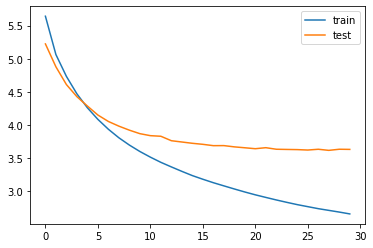

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### (5) 인퍼런스 모델
- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비

In [47]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [48]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

---

## Step4. 실제 결과와 요약문 비교하기 
- 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다.

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [51]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : actress kangana ranaut turned showstopper designer duo last day lakm fashion week mumbai kangana walked ramp embroidered gown designer duo spring summer collection called year old actress 
실제 요약 : kangana turns showstopper for at 
예측 요약 :  kangana ranaut walks out of queen at his career


원문 : cheteshwar pujara become third indian ninth overall batsman history bat five days test achieving feat first test sri lanka eden gardens pujara former indian cricketers ml ravi shastri achieved feat eden gardens 
실제 요약 : pujara third indian to bat on all days of test 
예측 요약 :  who is the first indian to be in odis


원문 : become first indian tribal language get wikipedia edition script wikipedia went live earlier month according report wikipedia india bangladesh nepal generated content page officials said written script spoken million people india 
실제 요약 : st indian tribal language to get own edition 
예측 요약 :  becomes st indian to launch satellite


원문 : supreme court banned sale serving liquo

---

## Step5. Summa을 이용해서 추출적 요약해보기

In [52]:
import requests
from summa.summarizer import summarize

### summarize(text, ratio, words, split)
- text(str) : 요약할 텍스트
- ratio(float, optional) : 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words(int or None, optional) : 출력에 포함될 단어 수
- split(bool, optional) : True면 문장 list/ False는 조인된 문자열을 반환
- 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로입력으로 넣을 수 있다

In [53]:
summa_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [54]:
for i in range(50):
    print('원문     : {}'.format(summa_data['text'][i]))
    print('실제 요약 : {}'.format(summa_data['headlines'][i]))
    print('예측 요약 : {}'.format(summarize(summa_data['text'][i], words=15)))
    print('\n')

원문     : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문     : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of 

---

## 정리

### (1) 추상적 요약
- 실제 headlines과 비슷하게 예측한 문장도 있는 반면에 완전히 다르게 예측한 문장들도 존재한다. 전혀 다른 단어들을 사용한 문장이 존재하고 문법이 맞지 않는 문장 등 모델의 성능 개선이 필요해 보인다. 사실 성능을 개선한다고 나아질까는 의문이다..!

### (2) 추출적 요약
- 출력에 포함될 단어수를 15개로 제한하고 예측을 해보았다. 원문에 있는 단어들을 가져오는 방식이라 그런지 실제 요약이랑 비슷한 예측들이 많았다. 그치만 요약을 잘 했는지는 사실 영어를 잘 몰라서 의문이다. 중간중간 보면 문장이 좀 긴 예측 요약들이 있는데 이는 ratio인자를 통해 조절할 수 있다. 그리고 보면 예측 요약이 안나온 것들이 있는데 출력에 포함될 단어수가 적어서인지.. 요약이 불가한건지.. 이점은 알아봐야 할 것 같다!

### (3) 회고
- 요약이라는건 원문을 얼마나 간결하게 잘 나타내었는가 인데..결과로 보면 추출적 요약이 더 좋은게 아닌가 생각이 들었다. 사실 글이라는건 관점에 따라 달리 보일 수 있는데 그래서 모델을 믿어도 되는게 맞나, loss값이 줄어든다해서 정확한게 맞나 프로젝트를 진행하면서 계속 의문점을 갖고 있었다. 그래도 처음 NLP를 했을 때보다 흥미가 생기고 관심이 생겼다. 아무래도,, cv와 nlp 중 고민을 진득히 해봐야 할 것 같다..ㅎㅎ!!

### 참고
- https://wikidocs.net/22893
- https://wikidocs.net/24996